In [1]:
from pathlib import Path
import sys

here = Path.cwd()
repo_root = next(p for p in [here, *here.parents] if (p / "pyproject.toml").exists())
src = repo_root / "src"
if str(src) not in sys.path:
    sys.path.insert(0, str(src))

In [2]:
## import random
from decimal import Decimal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from time import time
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from dataclasses import dataclass
from typing import Any, Dict

from optimal_ipr.distributions import value_distribution, build_theta_distribution
from optimal_ipr.probability import build_subjective_probability
from optimal_ipr.cost import build_cost_function
from optimal_ipr.fee import build_fee_schedule
from optimal_ipr.lookup import build_lookup_tables
from optimal_ipr.outcomes import welfare_outcomes

np.random.seed(42)
random.seed(42)

RESULTS_DIR = Path("results/robustness")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

def ensure_exists(path: Path) -> Path:
    """Ensure parent directory exists for the given path and return the path."""
    path.parent.mkdir(parents=True, exist_ok=True)
    return path

In [3]:
import inspect, optimal_ipr  # adds the package obj for inspection

print("package root:", optimal_ipr.__file__)
print("value_distribution:", inspect.getfile(optimal_ipr.distributions.value_distribution))
print("probability:", inspect.getfile(optimal_ipr.probability))
print("cost:", inspect.getfile(optimal_ipr.cost))
print("fee:", inspect.getfile(optimal_ipr.fee))
print("lookup:", inspect.getfile(optimal_ipr.lookup))
print("outcomes:", inspect.getfile(optimal_ipr.outcomes))

package root: C:\Users\jesse\OneDrive\Research\Optimal IPR in a BEPS World\model\optimal-ipr\src\optimal_ipr\__init__.py
value_distribution: C:\Users\jesse\OneDrive\Research\Optimal IPR in a BEPS World\model\optimal-ipr\src\optimal_ipr\distributions\value_distribution.py
probability: C:\Users\jesse\OneDrive\Research\Optimal IPR in a BEPS World\model\optimal-ipr\src\optimal_ipr\probability\__init__.py
cost: C:\Users\jesse\OneDrive\Research\Optimal IPR in a BEPS World\model\optimal-ipr\src\optimal_ipr\cost\__init__.py
fee: C:\Users\jesse\OneDrive\Research\Optimal IPR in a BEPS World\model\optimal-ipr\src\optimal_ipr\fee\__init__.py
lookup: C:\Users\jesse\OneDrive\Research\Optimal IPR in a BEPS World\model\optimal-ipr\src\optimal_ipr\lookup\__init__.py
outcomes: C:\Users\jesse\OneDrive\Research\Optimal IPR in a BEPS World\model\optimal-ipr\src\optimal_ipr\outcomes\__init__.py


In [4]:
def utilitarian(th):
    return 1.0

GOVERNMENT_PREFERENCES = {"utilitarian": utilitarian}
REGULATOR_PREFERENCES = {"welfarist_balanced": {"phi": 0.6, "psi": 0.3}}


@dataclass(frozen=True)
class Context:
    v_grid: np.ndarray
    v_weights: np.ndarray
    f: Any
    F: Any
    F_inv: Any
    c: Any
    Z: Any
    tau_d: float
    tau_f: float
    bar_beta_grid: np.ndarray
    gov_prefs: Dict[str, Any]
    reg_prefs: Dict[str, Any]


def build_context() -> Context:
    """Build invariant components of the model."""
    v_grid, v_weights = value_distribution(n_v=51, sigma=3.0)
    f, F, F_inv = build_theta_distribution(noise_level=0.20)
    c = build_cost_function(f, TARGET_AVG_COST_SHARE=0.5, C_MIN_COST=0.05, GAMMA_C_COST=3.0)
    Z = build_fee_schedule(zeta=0.04, fee_M=1.5)
    tau_d = 0.20
    tau_f = 0.05
    bar_beta_grid = np.linspace(0.0, 1.0, 101)
    return Context(v_grid, v_weights, f, F, F_inv, c, Z, tau_d, tau_f, bar_beta_grid,
                   GOVERNMENT_PREFERENCES, REGULATOR_PREFERENCES)

ctx = build_context()

In [5]:
def run_for_m_comp(m: float, ctx: Context) -> dict:
    """Run government optimization for a given M_COMP."""
    p = build_subjective_probability(base_k=1.2, m_comp=m, F=ctx.F, F_inv=ctx.F_inv)
    F_scalar = lambda t: float(ctx.F(np.array([t])))
    theta_tilde_table, theta_winner_table, *_ = build_lookup_tables(
        p, ctx.c, ctx.Z, ctx.f, F_scalar, ctx.tau_d, ctx.tau_f, ctx.bar_beta_grid, ctx.v_grid, seed=42
    )
    results_table = welfare_outcomes(
        tau_d=ctx.tau_d,
        tau_f=ctx.tau_f,
        gov_prefs=ctx.gov_prefs,
        reg_prefs=ctx.reg_prefs,
        v_grid=ctx.v_grid,
        v_weights=ctx.v_weights,
        theta_tilde_table=theta_tilde_table,
        theta_winner_table=theta_winner_table,
        f=ctx.f,
        F=ctx.F,
        F_inv=ctx.F_inv,
        p=p,
        c=ctx.c,
        Z=ctx.Z,
        feas=False,
    )
    if results_table.empty:
        raise ValueError("welfare_outcomes returned an empty table")
    bar_beta_opt = float(results_table.loc[0, 'Optimal Patent Breadth Cap'])
    bar_star_opt = float(results_table.loc[0, 'Expected Optimal Patent Breadth Granted'])
    welfare_pct_change = float(results_table.loc[0, 'Welfare % Change'])
    innov_pct_change = float(results_table.loc[0, 'Innovator Welfare % Change'])
    imit_pct_change = float(results_table.loc[0, 'Imitator Welfare % Change'])
    non_inv_pct_change = float(results_table.loc[0, 'Non-Investor Welfare % Change'])
    return {
        'target_m_comp': m,
        'bar_beta_opt': bar_beta_opt,
        'bar_star_opt': bar_star_opt,
        'welfare_pct_change': welfare_pct_change,
        'innov_welfare_pct_change': innov_pct_change,
        'imit_welfare_pct_change': imit_pct_change,
        'non_invest_welfare_pct_change': non_inv_pct_change,
    }

In [6]:
m_comp_grid = [round(0 + 5 * i, 2) for i in range(16)]
start_time = time()
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(run_for_m_comp)(s, ctx) for s in tqdm(m_comp_grid)
)
total_time = time() - start_time
results_df = pd.DataFrame(results).sort_values("target_m_comp").reset_index(drop=True)
results_df

  0%|          | 0/16 [00:00<?, ?it/s]

,target_m_comp,bar_beta_opt,bar_star_opt,welfare_pct_change,innov_welfare_pct_change,imit_welfare_pct_change,non_invest_welfare_pct_change
0,0,0.06,0.06,294.019084,-99.300631,106.500513,1785.998452
1,5,0.91,0.91,3.050565,-9.331189,13.087976,170.999907
2,10,0.98,0.98,0.380712,-2.071088,5.332557,38.000003
3,15,1.00,1.00,0.000000,0.000000,0.000000,0.000000
4,20,1.00,1.00,0.000000,0.000000,NaN,0.000000
5,25,1.00,1.00,0.000000,0.000000,NaN,0.000000
6,30,1.00,1.00,0.000000,0.000000,NaN,0.000000
7,35,1.00,1.00,0.000000,0.000000,NaN,0.000000
8,40,1.00,1.00,0.000000,0.000000,NaN,0.000000
9,45,1.00,1.00,0.000000,0.000000,NaN,0.000000


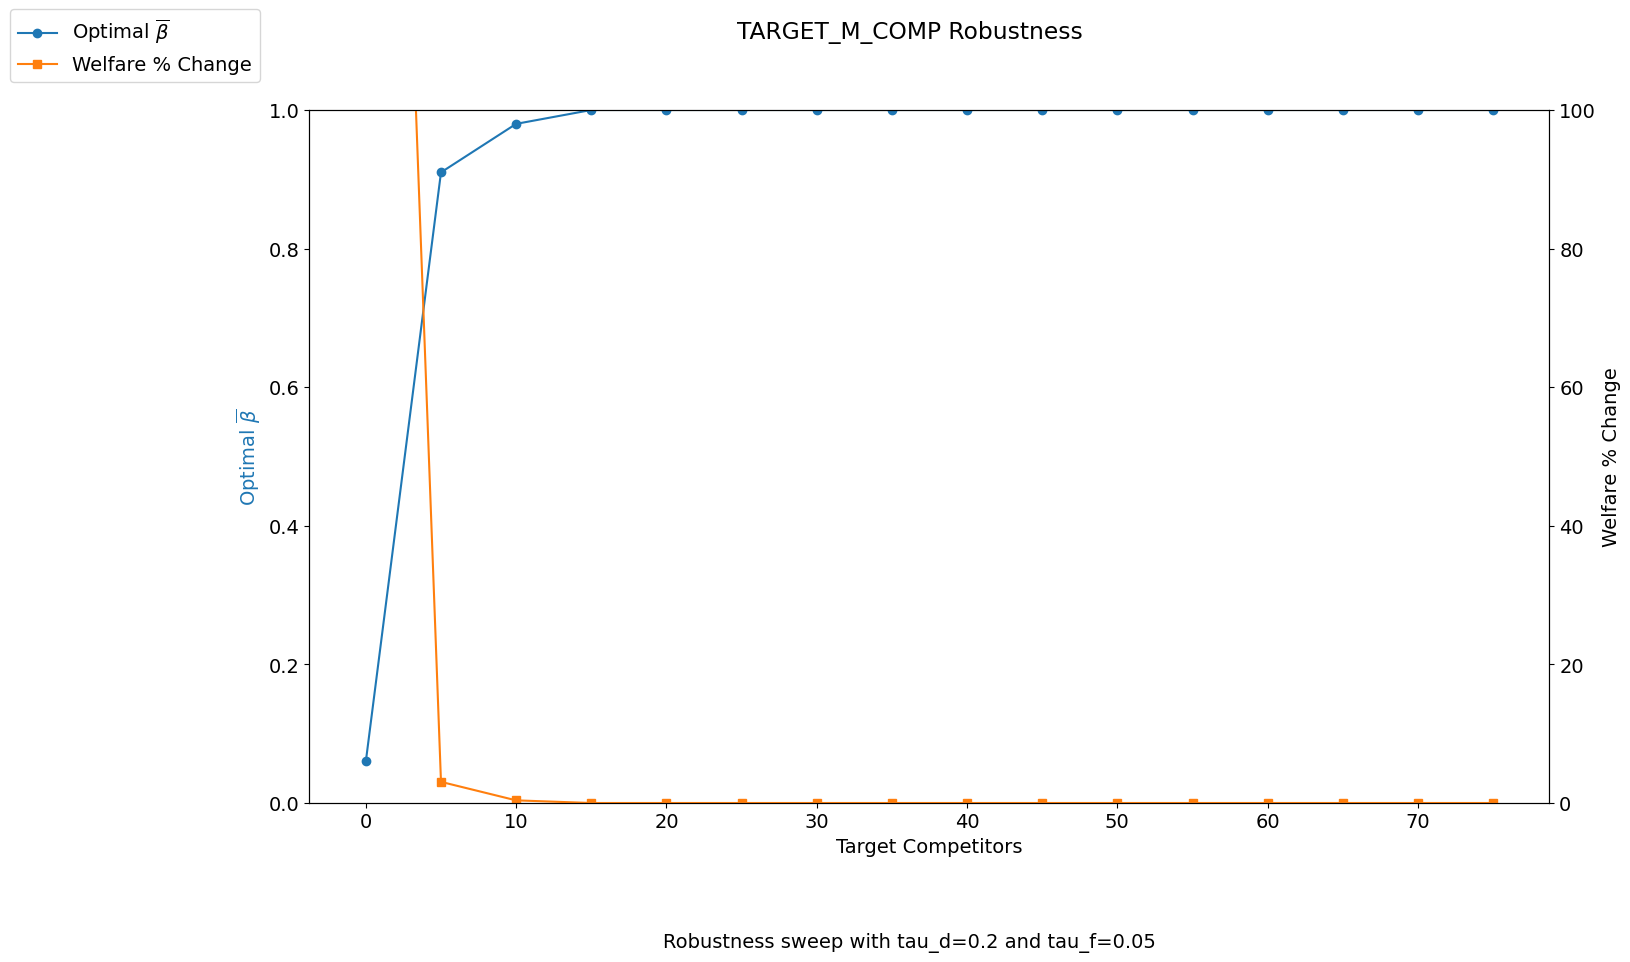

In [7]:
csv_path = ensure_exists(RESULTS_DIR / "m_comp_sweep.csv")
results_df.to_csv(csv_path, index=False)

plt.rcParams.update({"font.size": 14})
fig, ax1 = plt.subplots(figsize=(16, 9))
ax1.set_xlabel("Target Competitors")
ax1.set_ylabel(r"Optimal $\overline{\beta}$", color="tab:blue")
ax1.set_ylim(0, 1)
ax1.plot(results_df["target_m_comp"], results_df["bar_beta_opt"], marker="o", color="tab:blue", label=r"Optimal $\overline{\beta}$")
ax2 = ax1.twinx()
ax2.set_ylabel("Welfare % Change")
ax2.set_ylim(0, 100)
ax2.plot(results_df["target_m_comp"], results_df["welfare_pct_change"], marker="s", color="tab:orange", label="Welfare % Change")
fig.legend(loc="lower right", bbox_to_anchor=(0.1, 0.9))
caption = "Robustness sweep with tau_d=0.2 and tau_f=0.05"
fig.suptitle("TARGET_M_COMP Robustness")
fig.text(0.5, -0.05, caption, ha="center")
png_path = ensure_exists(RESULTS_DIR / "m_comp_sweep.png")
fig.savefig(png_path, dpi=100, bbox_inches="tight")
plt.show()

In [8]:
baseline_m_comp = 5
baseline_calc = run_for_m_comp(baseline_m_comp, ctx)
baseline_row = results_df.loc[results_df['target_m_comp'] == baseline_m_comp].iloc[0]

tol_beta = 1e-6
tol_welfare = 1e-6
beta_diff = abs(baseline_calc['bar_beta_opt'] - baseline_row['bar_beta_opt'])
welfare_diff = abs(baseline_calc['welfare_pct_change'] - baseline_row['welfare_pct_change'])

if beta_diff <= tol_beta and welfare_diff <= tol_welfare:
    status = "passed"
else:
    status = "FAILED"
    raise AssertionError("Baseline cross-check failed")

print(f"Baseline cross-check {status}: Δbar_beta_opt={beta_diff:.3e}, Δwelfare_pct_change={welfare_diff:.3e}")
print(f"Total wall time: {total_time:.2f} s; per-share avg: {total_time/len(m_comp_grid):.2f} s")
print(f"{len(m_comp_grid)} shares evaluated")
print(f"CSV saved to {csv_path}")
print(f"PNG saved to {png_path}")

Processing tau pairs:   0%|          | 0/1 [00:00<?, ?it/s]

Baseline cross-check passed: Δbar_beta_opt=0.000e+00, Δwelfare_pct_change=0.000e+00
Total wall time: 41.07 s; per-share avg: 2.57 s
16 shares evaluated
CSV saved to results\robustness\m_comp_sweep.csv
PNG saved to results\robustness\m_comp_sweep.png


In [9]:
display(results_df.head(5))
display(results_df.tail(5))

,target_m_comp,bar_beta_opt,bar_star_opt,welfare_pct_change,innov_welfare_pct_change,imit_welfare_pct_change,non_invest_welfare_pct_change
0,0,0.06,0.06,294.019084,-99.300631,106.500513,1785.998452
1,5,0.91,0.91,3.050565,-9.331189,13.087976,170.999907
2,10,0.98,0.98,0.380712,-2.071088,5.332557,38.000003
3,15,1.00,1.00,0.000000,0.000000,0.000000,0.000000
4,20,1.00,1.00,0.000000,0.000000,NaN,0.000000


,target_m_comp,bar_beta_opt,bar_star_opt,welfare_pct_change,innov_welfare_pct_change,imit_welfare_pct_change,non_invest_welfare_pct_change
11,55,1.0,1.0,0.0,0.0,NaN,0.0
12,60,1.0,1.0,0.0,0.0,NaN,0.0
13,65,1.0,1.0,0.0,0.0,NaN,0.0
14,70,1.0,1.0,0.0,0.0,NaN,0.0
15,75,1.0,1.0,0.0,0.0,NaN,0.0
